In [1]:
# Import required libraries and scripts
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.data_loader import load_data, convert_date_columns
from src.data_preprocessing import preprocess_data
from src.feature_engineering import feature_engineer, encode_target

# Set the path to your data directory
DB_PATH = 'data'

# Load the data
weather_df, air_quality_df = load_data(DB_PATH)


In [2]:
# Display first few rows of the dataset
display(weather_df.head())

# Show data types of each column
display(weather_df.dtypes)

,data_ref,date,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Min Temperature (deg C),Maximum Temperature (deg C),Min Wind Speed (km/h),Max Wind Speed (km/h),Sunshine Duration (hrs),Cloud Cover (%),Wet Bulb Temperature (deg F),Relative Humidity (%),Air Pressure (hPa),Dew Point Category,Wind Direction,Daily Solar Panel Efficiency
0,4d4d20c2-0167-4bc2-a62c-4df6e11fb2ea,01/04/2014,-,2,2,2,28.4,32.4,7.5,25.9,8.07,18.0,-59.3,100.0,1006,VH,W,High
1,c9d3c825-fd94-4e61-a4bc-2cf0f2208de0,02/04/2014,0,0,0,--,28.8,32.6,--,33.1,7.57,23.0,59.2,100.0,1005,Very High,S,Medium
2,6d445ffb-d4c2-4f94-a27e-224fabe46d10,03/04/2014,0,0,0,0,29.3,--,--,43.2,6.72,16.0,59.7,98.5,1005,Low,E,Medium
3,7a404c50-710f-451a-9a42-a66bb783a3d0,04/04/2014,0,0,0,0,28.6,32.4,7.4,33.1,7.55,20.0,59.1,100.0,1011,Very High,W,Medium
4,0d3194a7-ad1a-456e-9bf8-b1bae730977b,05/04/2014,23.4,15.2,17.2,17.4,26.4,28,5.4,28.1,5.27,74.0,58.9,100.0,1012,Very High,east,Low


data_ref                          object
date                              object
Daily Rainfall Total (mm)         object
Highest 30 Min Rainfall (mm)      object
Highest 60 Min Rainfall (mm)      object
Highest 120 Min Rainfall (mm)     object
Min Temperature (deg C)           object
Maximum Temperature (deg C)       object
Min Wind Speed (km/h)             object
Max Wind Speed (km/h)             object
Sunshine Duration (hrs)          float64
Cloud Cover (%)                  float64
Wet Bulb Temperature (deg F)     float64
Relative Humidity (%)            float64
Air Pressure (hPa)                 int64
Dew Point Category                object
Wind Direction                    object
Daily Solar Panel Efficiency      object
dtype: object

data_ref                          0
date                              0
Daily Rainfall Total (mm)         0
Highest 30 Min Rainfall (mm)      0
Highest 60 Min Rainfall (mm)      0
Highest 120 Min Rainfall (mm)     0
Min Temperature (deg C)           0
Maximum Temperature (deg C)       0
Min Wind Speed (km/h)             0
Max Wind Speed (km/h)            15
Sunshine Duration (hrs)          16
Cloud Cover (%)                  16
Wet Bulb Temperature (deg F)      0
Relative Humidity (%)             0
Air Pressure (hPa)                0
Dew Point Category                0
Wind Direction                    0
Daily Solar Panel Efficiency      0
dtype: int64

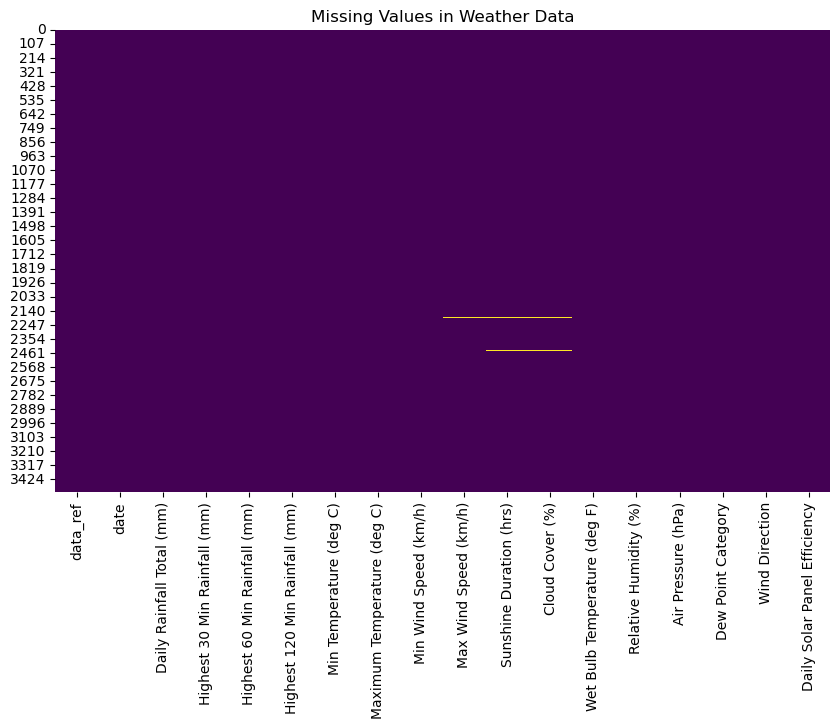

In [3]:
# Count missing values in each column
missing_values = weather_df.isnull().sum()
display(missing_values)

# Visualize missing values
plt.figure(figsize=(10, 6))
sns.heatmap(weather_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values in Weather Data')
plt.show()

In [4]:
# Identify columns with infinite values
infinite_values = weather_df.isin([np.inf, -np.inf]).sum()
display(infinite_values)


data_ref                         0
date                             0
Daily Rainfall Total (mm)        0
Highest 30 Min Rainfall (mm)     0
Highest 60 Min Rainfall (mm)     0
Highest 120 Min Rainfall (mm)    0
Min Temperature (deg C)          0
Maximum Temperature (deg C)      0
Min Wind Speed (km/h)            0
Max Wind Speed (km/h)            0
Sunshine Duration (hrs)          0
Cloud Cover (%)                  0
Wet Bulb Temperature (deg F)     0
Relative Humidity (%)            0
Air Pressure (hPa)               0
Dew Point Category               0
Wind Direction                   0
Daily Solar Panel Efficiency     0
dtype: int64

In [5]:
# Identify columns with negative values
negative_values = weather_df.select_dtypes(include=[np.number]).lt(0).sum()
display(negative_values)


Sunshine Duration (hrs)           0
Cloud Cover (%)                   0
Wet Bulb Temperature (deg F)    178
Relative Humidity (%)             0
Air Pressure (hPa)                0
dtype: int64

In [6]:
# Summary statistics before cleaning
summary_stats_before = weather_df.describe()
display(summary_stats_before)


,Sunshine Duration (hrs),Cloud Cover (%),Wet Bulb Temperature (deg F),Relative Humidity (%),Air Pressure (hPa)
count,3501.000000,3501.000000,3517.000000,3517.000000,3517.000000
mean,7.018320,28.682376,52.946062,97.366761,1008.668467
std,1.389904,20.788299,25.842174,5.043705,3.513724
min,0.000000,2.000000,-60.700000,68.600000,998.000000
25%,6.710000,17.000000,58.400000,96.700000,1006.000000
50%,7.400000,22.000000,58.900000,100.000000,1009.000000
75%,7.840000,30.000000,59.400000,100.000000,1011.000000
max,9.150000,100.000000,61.800000,100.000000,1020.000000


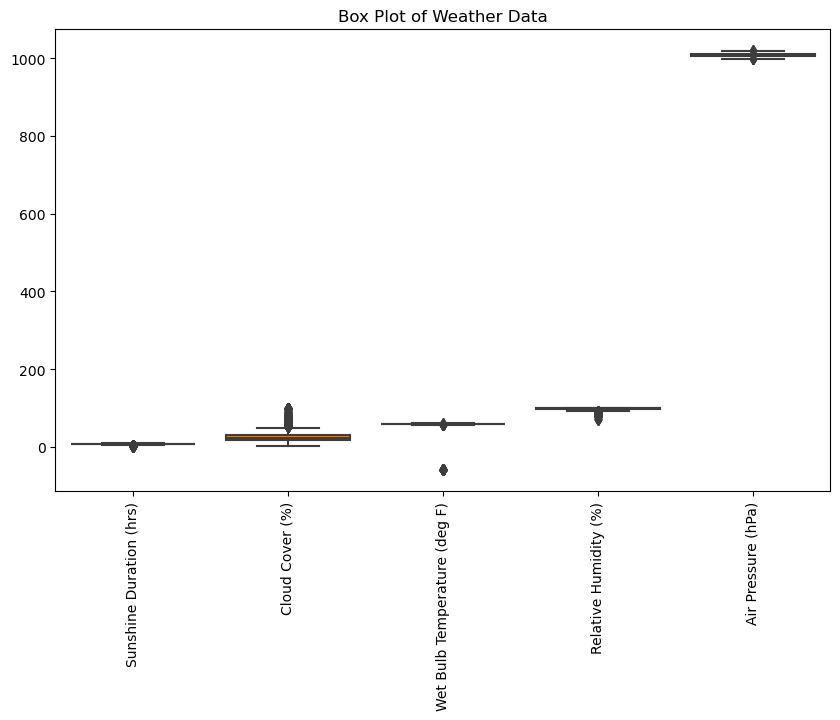

In [7]:
# Box plots to visualize outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=weather_df.select_dtypes(include=[np.number]))
plt.title('Box Plot of Weather Data')
plt.xticks(rotation=90)
plt.show()



# Conclusion

Based on the initial exploration, we identified several issues in the weather dataset, including:
- Missing values in multiple columns.
- Presence of infinite values.
- Negative values in columns where they are not logically possible (e.g., wind speed).
- Outliers in various columns.

These findings informed the data cleaning process applied in the preprocessing script. The cleaned dataset is now ready for further analysis and modeling.


In [8]:
# Check original 'Daily Solar Panel Efficiency' values
print("Original 'Daily Solar Panel Efficiency' values:")
print(weather_df['Daily Solar Panel Efficiency'].describe())

# Convert date columns to datetime
weather_df, air_quality_df = convert_date_columns(weather_df, air_quality_df)

Original 'Daily Solar Panel Efficiency' values:
count       3517
unique         3
top       Medium
freq        1932
Name: Daily Solar Panel Efficiency, dtype: object


In [9]:
# Save the 'Daily Solar Panel Efficiency' column before preprocessing
daily_efficiency = weather_df['Daily Solar Panel Efficiency'].copy()

In [10]:
# Preprocess the data
weather_df_scaled, air_quality_df = preprocess_data(weather_df, air_quality_df)

C:\Users\Ken\Documents\AISG Assessment 2\AIAP 18 Assessment\src\data_preprocessing.py:80: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  weather_df['rainfall_intensity'].replace([np.inf, -np.inf], 1e6, inplace=True)


# Data Cleaning Summary

During the data cleaning process, we addressed the following issues:
- Replaced missing values using forward fill method.
- Identified and handled infinite values by replacing them with appropriate large finite values.
- Detected and replaced negative values in columns where they are not logical (e.g., wind speed).
- Ensured proper data types and handled any inconsistencies.


Summary Statistics for Weather Data:
                                date  Daily Rainfall Total (mm)  \
count                           3517                3517.000000   
mean   2018-08-18 05:47:36.866647552                   5.250711   
min              2014-04-01 00:00:00                   0.000000   
25%              2016-06-02 00:00:00                   0.000000   
50%              2018-08-18 00:00:00                   0.000000   
75%              2020-10-27 00:00:00                   4.000000   
max              2022-12-31 00:00:00                 210.600000   
std                              NaN                  12.472992   

       Highest 30 Min Rainfall (mm)  Highest 60 Min Rainfall (mm)  \
count                   3517.000000                   3517.000000   
mean                       3.159340                      3.788172   
min                        0.000000                      0.000000   
25%                        0.000000                      0.000000   
50%           

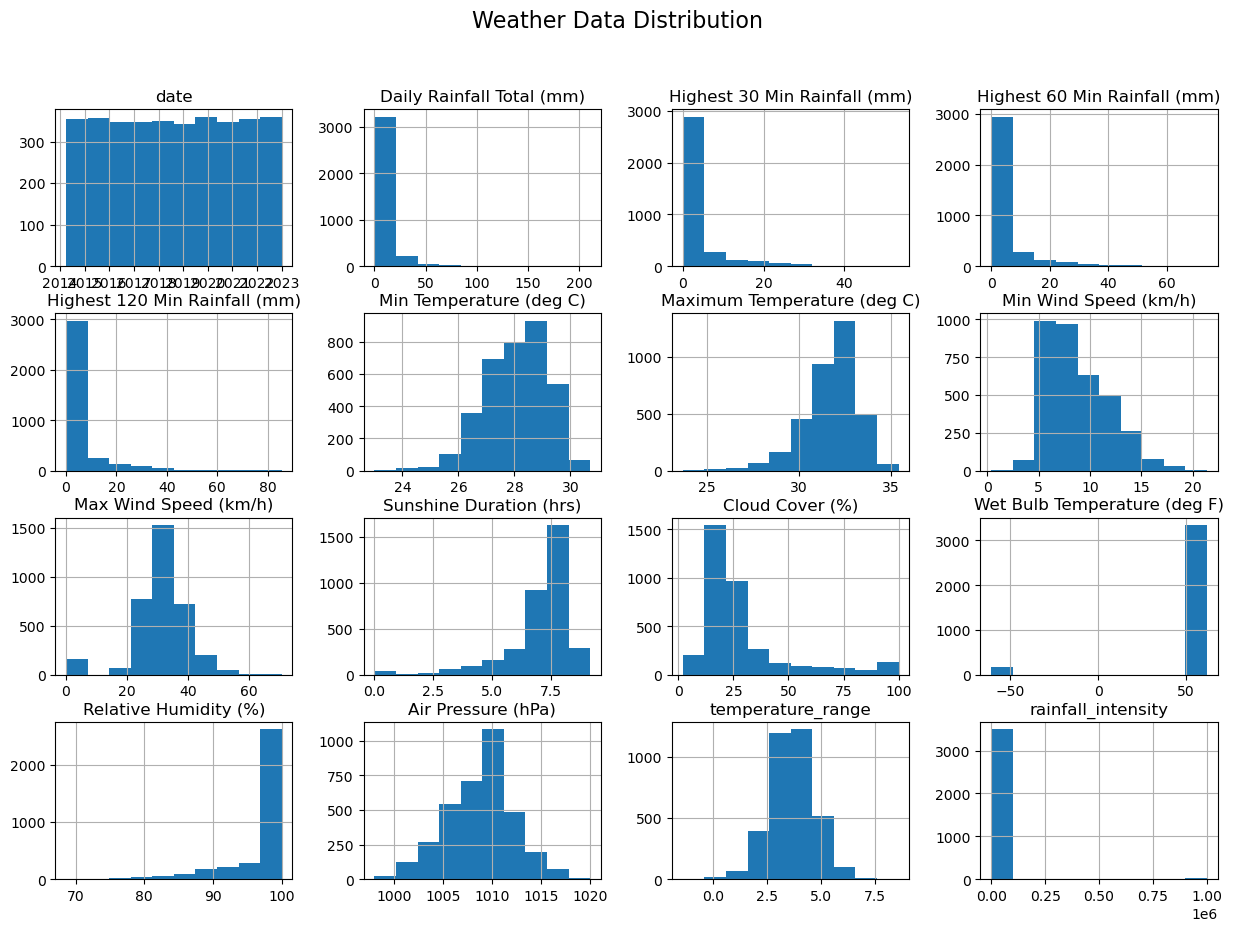

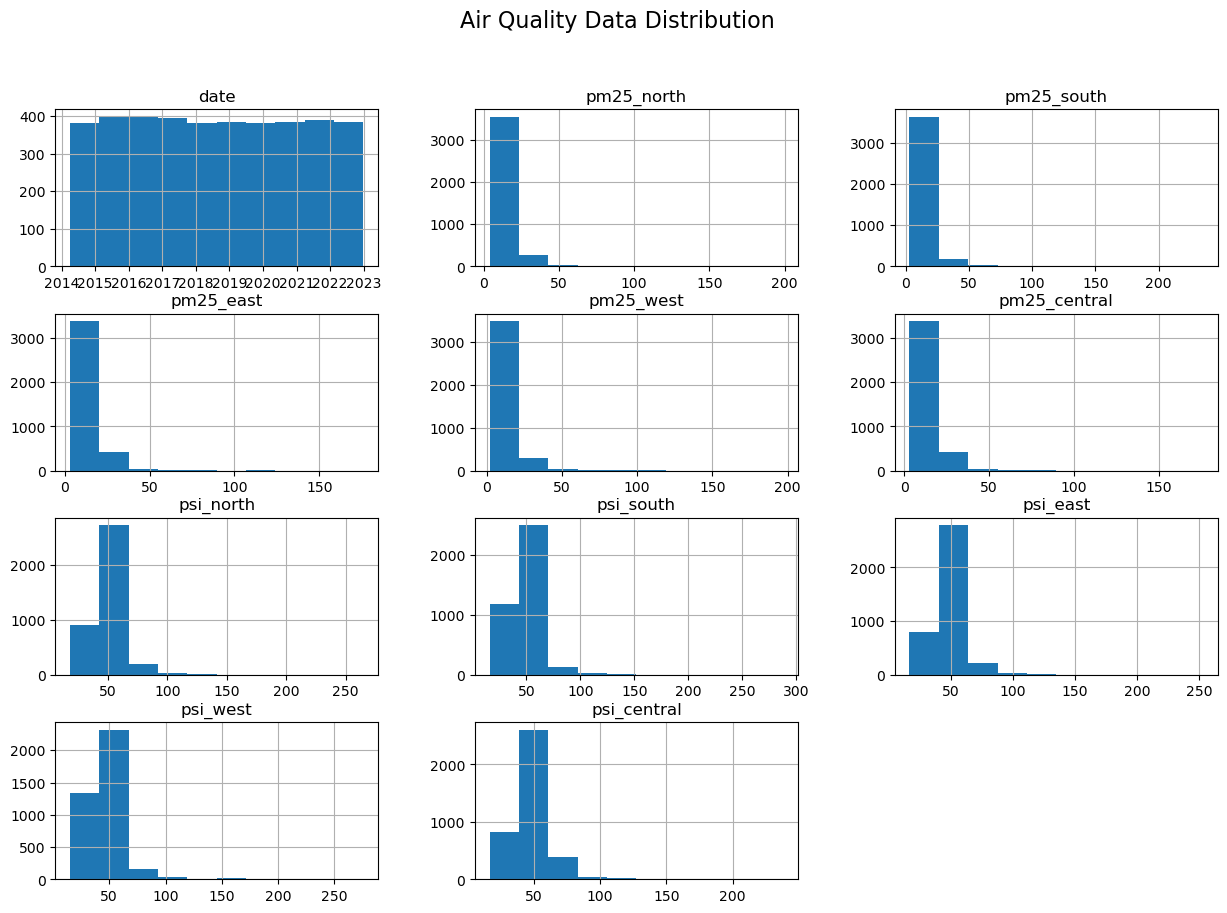

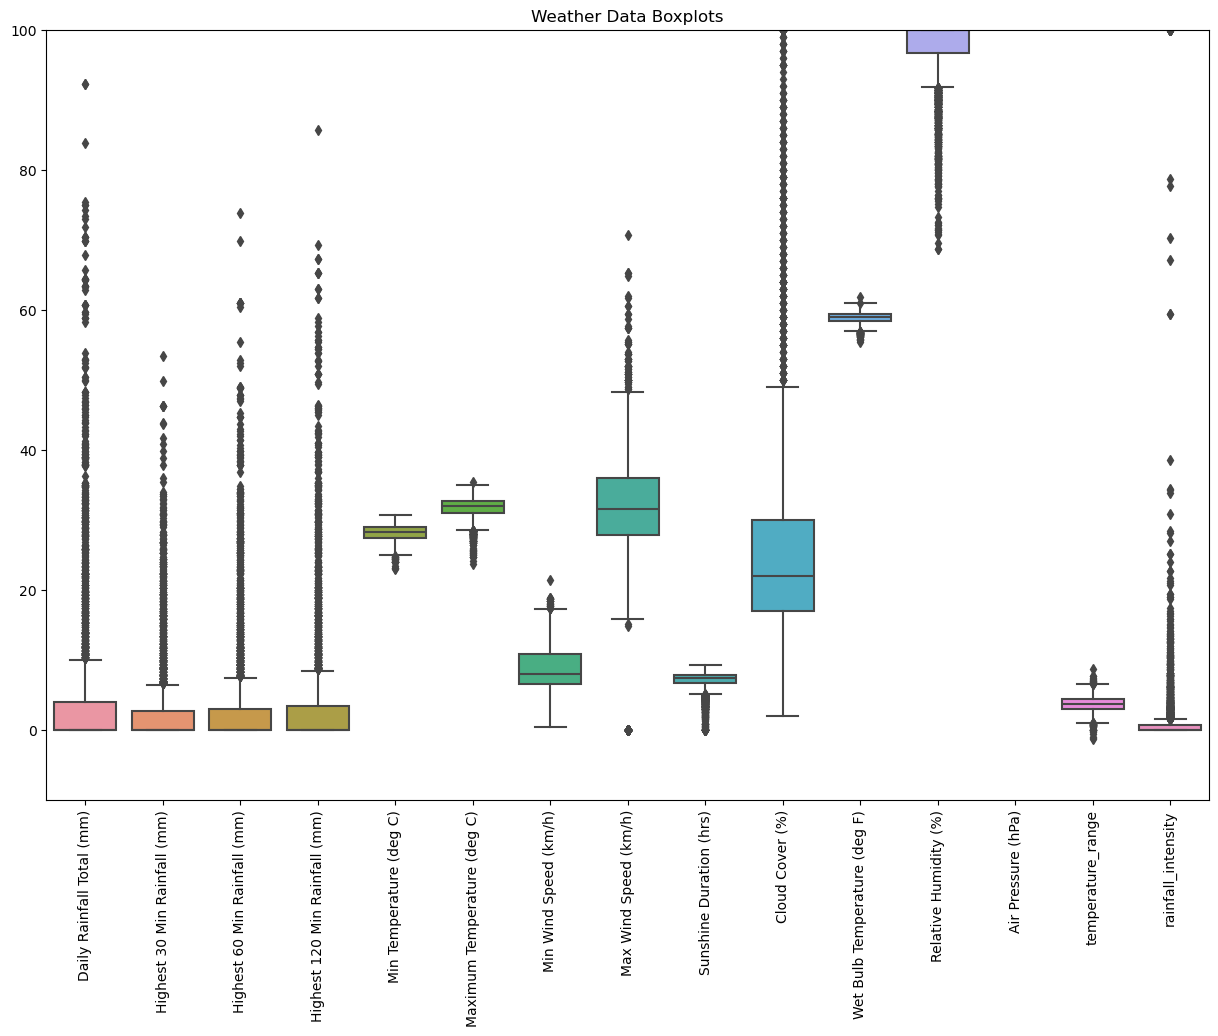

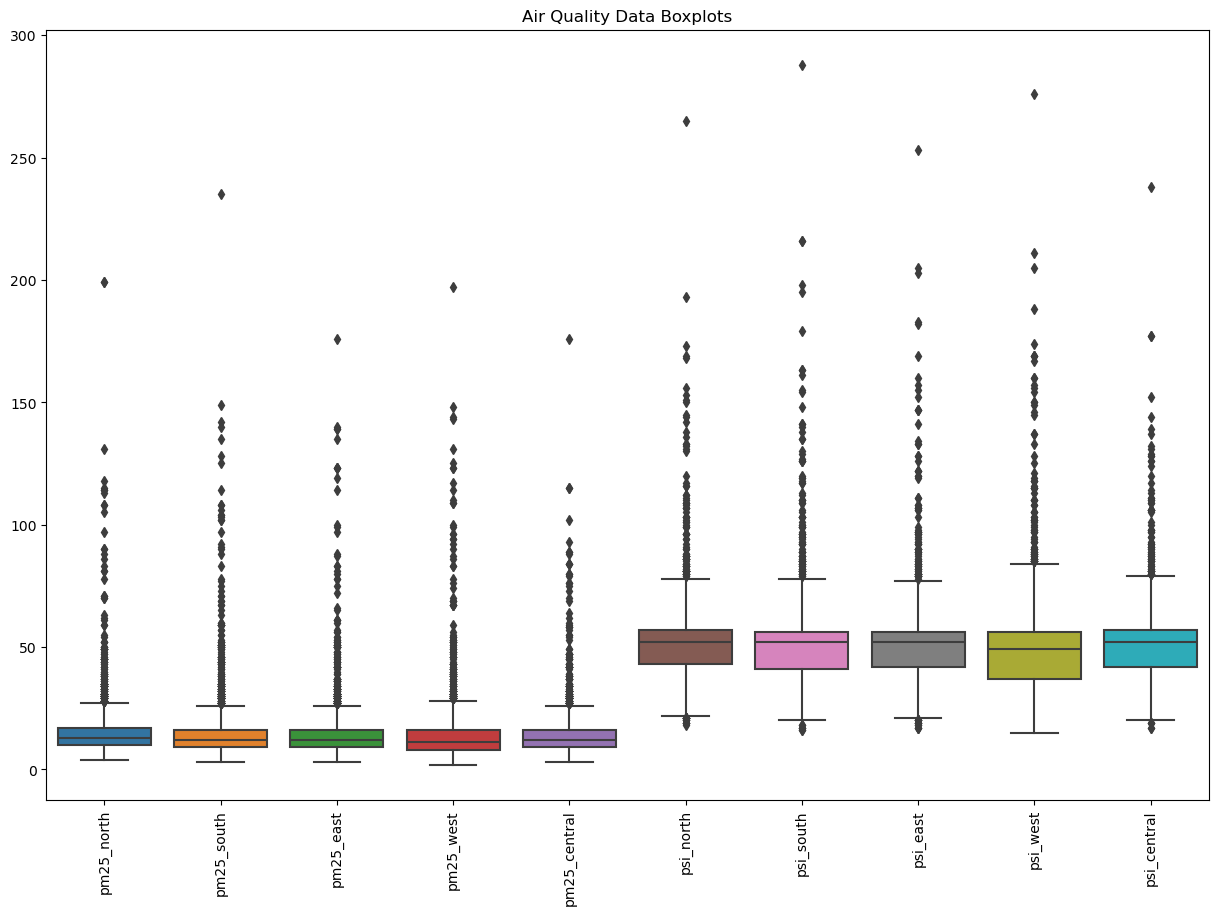

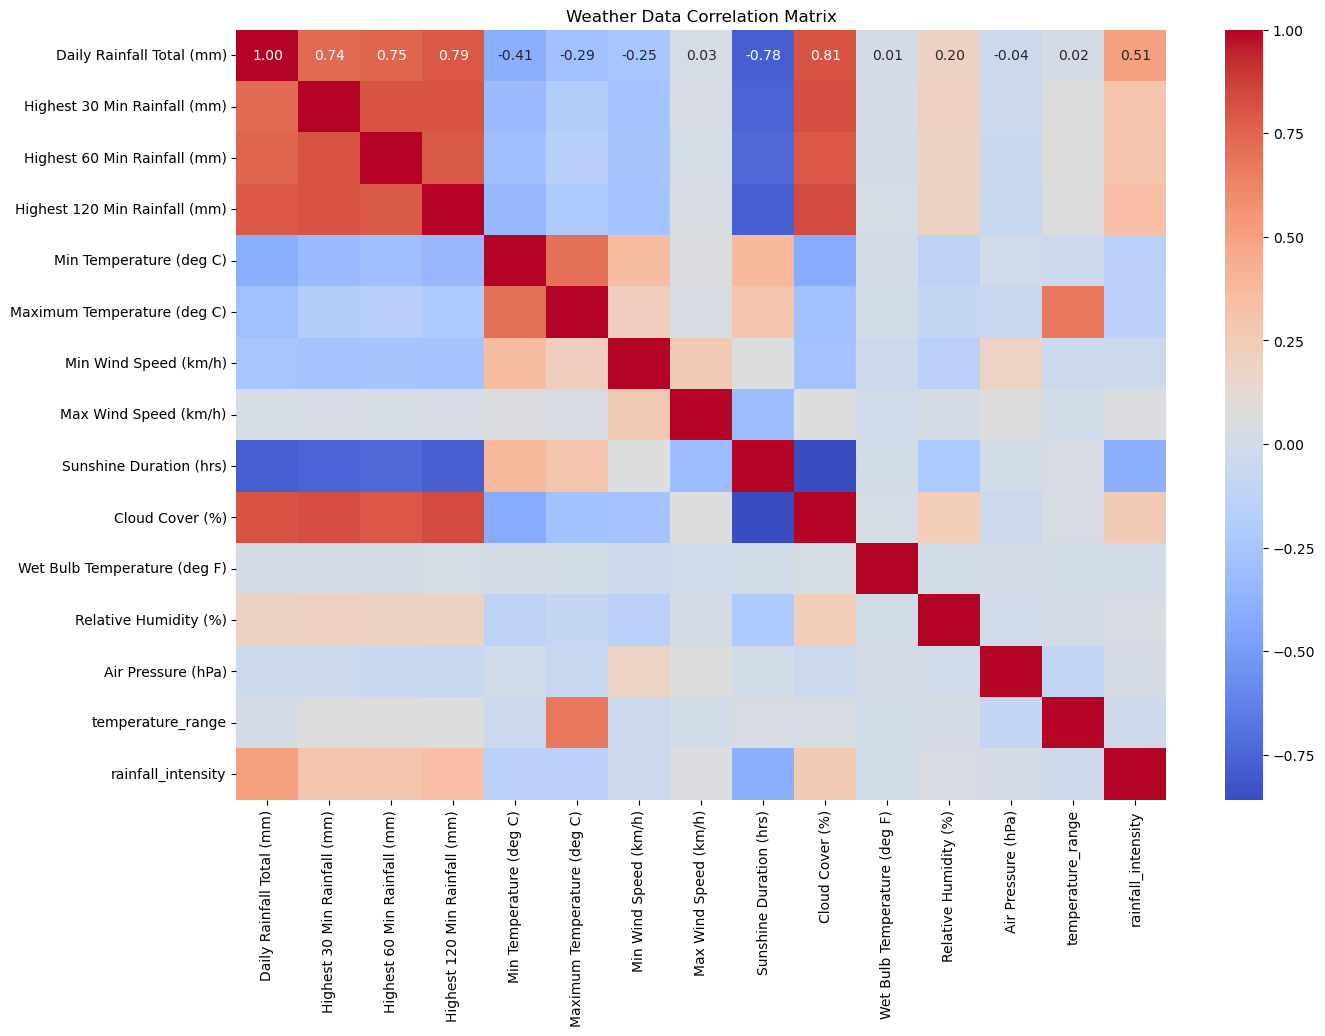

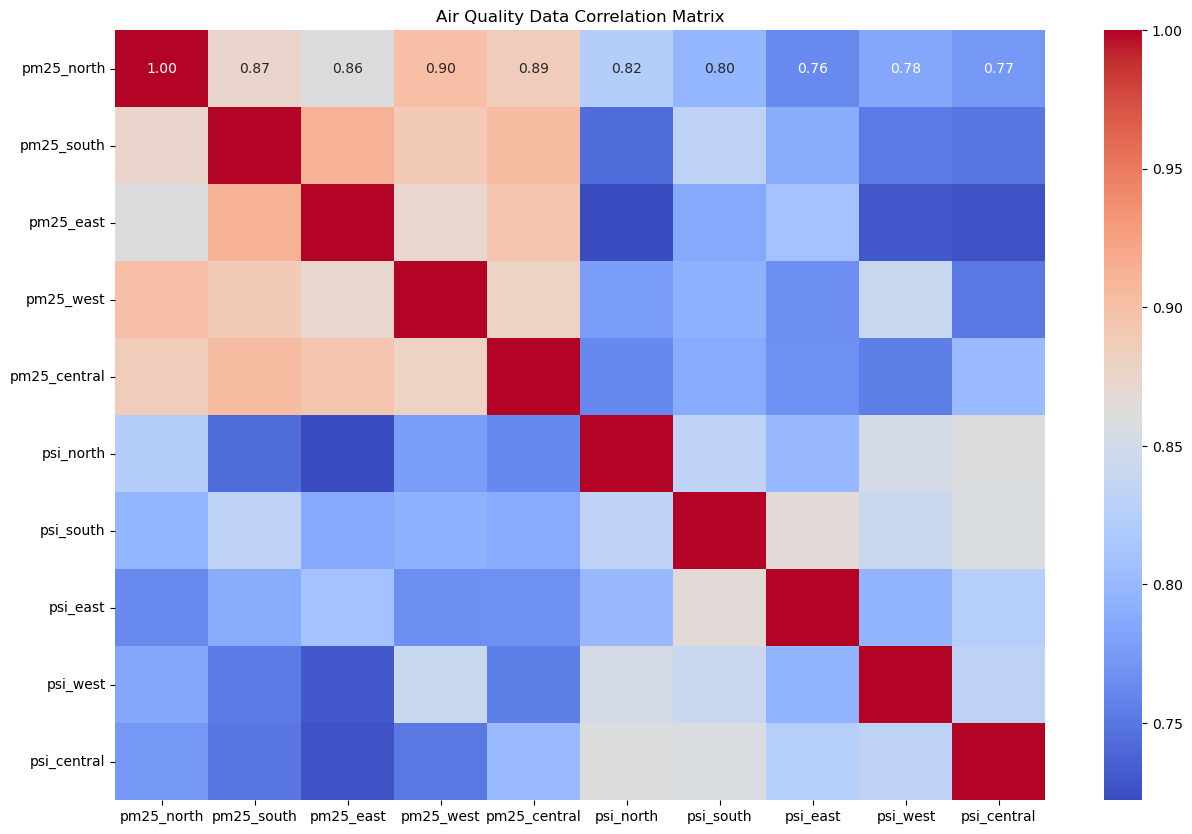

In [11]:
# Data Verification after Cleanup

import matplotlib.pyplot as plt
import seaborn as sns

# Summary statistics
print("Summary Statistics for Weather Data:")
print(weather_df.describe())

print("Summary Statistics for Air Quality Data:")
print(air_quality_df.describe())

# Histograms
weather_df.hist(figsize=(15, 10))
plt.suptitle('Weather Data Distribution', fontsize=16)
plt.show()

air_quality_df.hist(figsize=(15, 10))
plt.suptitle('Air Quality Data Distribution', fontsize=16)
plt.show()

# Boxplots with capped extreme values for better visualization
plt.figure(figsize=(15, 10))

# Cap extreme values in rainfall_intensity
capped_weather_df = weather_df.copy()
capped_weather_df['rainfall_intensity'] = capped_weather_df['rainfall_intensity'].apply(lambda x: min(x, 100))

sns.boxplot(data=capped_weather_df)
plt.title('Weather Data Boxplots')
plt.xticks(rotation=90)
plt.ylim(-10, 100)  # Adjust this range as needed
plt.show()

plt.figure(figsize=(15, 10))
sns.boxplot(data=air_quality_df)
plt.title('Air Quality Data Boxplots')
plt.xticks(rotation=90)
plt.show()

# Correlation Matrix for Weather Data (excluding non-numeric columns)
plt.figure(figsize=(15, 10))
numeric_weather_df = weather_df.select_dtypes(include=[np.number])
correlation_matrix = numeric_weather_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Weather Data Correlation Matrix')
plt.show()

# Correlation Matrix for Air Quality Data (excluding non-numeric columns)
plt.figure(figsize=(15, 10))
numeric_air_quality_df = air_quality_df.select_dtypes(include=[np.number])
correlation_matrix = numeric_air_quality_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Air Quality Data Correlation Matrix')
plt.show()


# Summary of Key Findings

# Key Findings from EDA

## Summary Statistics
- The weather data and air quality data have been successfully loaded and preprocessed.
- Summary statistics provide a good overview of the central tendency, dispersion, and shape of the data’s distribution.

## Histograms
- The histograms indicate the distribution of numerical features.
- Most features show a normal distribution, while some, like rainfall-related features, show skewness.

## Boxplots
- Boxplots reveal the presence of outliers in the dataset.
- For the weather data, extreme outliers in `rainfall_intensity` were capped for better visualization.
- Air quality data also shows variability across different regions.

## Correlation Matrix
- The correlation matrix for weather data shows significant correlations between:
  - `Max Temperature` and `Min Temperature`
  - `Sunshine Duration` and `Daily Rainfall Total`
- The correlation matrix for air quality data highlights:
  - Strong correlations between different regions' PM2.5 levels.
  - Strong correlations between different regions' PSI levels.

## Data Preparation Insights
- The data has been cleaned, and all missing values have been handled.
- Extreme outliers in `rainfall_intensity` were capped to ensure they do not skew the analysis.
- Numeric features were standardized for uniformity.

## Implications for Next Steps
- Features with high correlations can be considered for dimensionality reduction techniques such as PCA.
- The presence of outliers should be considered when choosing algorithms that are sensitive to outliers.
- Strong correlations in air quality data suggest potential redundancy, which could be addressed through feature selection.

With the data cleaned and ready, we can now proceed to the feature engineering and model training phases of our machine learning pipeline.

In [12]:
# Apply feature engineering
weather_df = feature_engineer(weather_df_scaled)

print("Columns in weather_df:")
print(weather_df.columns)

# Merge the 'Daily Solar Panel Efficiency' column back
weather_df['Daily Solar Panel Efficiency'] = daily_efficiency.values

Columns in weather_df:
Index(['Daily Rainfall Total (mm)', 'Highest 30 Min Rainfall (mm)',
       'Highest 60 Min Rainfall (mm)', 'Highest 120 Min Rainfall (mm)',
       'Min Temperature (deg C)', 'Maximum Temperature (deg C)',
       'Min Wind Speed (km/h)', 'Max Wind Speed (km/h)',
       'Sunshine Duration (hrs)', 'Cloud Cover (%)',
       'Wet Bulb Temperature (deg F)', 'Relative Humidity (%)',
       'Air Pressure (hPa)', 'temperature_range', 'rainfall_intensity',
       'total_rainfall'],
      dtype='object')


In [13]:
print("Columns in weather_df:")
print(weather_df.columns)

# Convert 'Daily Solar Panel Efficiency' to numeric, forcing errors to NaN
#weather_df['Daily Solar Panel Efficiency'] = pd.to_numeric(weather_df['Daily Solar Panel Efficiency'], errors='coerce')



Columns in weather_df:
Index(['Daily Rainfall Total (mm)', 'Highest 30 Min Rainfall (mm)',
       'Highest 60 Min Rainfall (mm)', 'Highest 120 Min Rainfall (mm)',
       'Min Temperature (deg C)', 'Maximum Temperature (deg C)',
       'Min Wind Speed (km/h)', 'Max Wind Speed (km/h)',
       'Sunshine Duration (hrs)', 'Cloud Cover (%)',
       'Wet Bulb Temperature (deg F)', 'Relative Humidity (%)',
       'Air Pressure (hPa)', 'temperature_range', 'rainfall_intensity',
       'total_rainfall', 'Daily Solar Panel Efficiency'],
      dtype='object')


In [14]:
# Apply target encoding
weather_df = encode_target(weather_df)

# Display the DataFrame to ensure everything is correct
print(weather_df.head())

   Daily Rainfall Total (mm)  Highest 30 Min Rainfall (mm)  \
0                   0.000000                     -0.175472   
1                  -0.421026                     -0.478181   
2                  -0.421026                     -0.478181   
3                  -0.421026                     -0.478181   
4                   1.455294                      1.822412   

   Highest 60 Min Rainfall (mm)  Highest 120 Min Rainfall (mm)  \
0                     -0.213450                      -0.240260   
1                     -0.452186                      -0.240260   
2                     -0.452186                      -0.449525   
3                     -0.452186                      -0.449525   
4                      1.600943                       1.371085   

   Min Temperature (deg C)  Maximum Temperature (deg C)  \
0                 0.304931                     0.455472   
1                 0.670330                     0.590624   
2                 1.127077                     0.5906

In [15]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
# Display specific columns
print(weather_df[['Daily Solar Panel Efficiency', 'efficiency_label']].head(100))

   Daily Solar Panel Efficiency  efficiency_label
0                          High                 2
1                        Medium                 1
2                        Medium                 1
3                        Medium                 1
4                           Low                 0
5                           Low                 0
6                           Low                 0
7                           Low                 0
8                        Medium                 1
9                        Medium                 1
10                       Medium                 1
11                          Low                 0
12                       Medium                 1
13                       Medium                 1
14                       Medium                 1
15                         High                 2
16                          Low                 0
17                       Medium                 1
18                       Medium                 1


In [16]:
#Double check no missing values in each column
print(weather_df.isnull().sum())

Daily Rainfall Total (mm)        0
Highest 30 Min Rainfall (mm)     0
Highest 60 Min Rainfall (mm)     0
Highest 120 Min Rainfall (mm)    0
Min Temperature (deg C)          0
Maximum Temperature (deg C)      0
Min Wind Speed (km/h)            0
Max Wind Speed (km/h)            0
Sunshine Duration (hrs)          0
Cloud Cover (%)                  0
Wet Bulb Temperature (deg F)     0
Relative Humidity (%)            0
Air Pressure (hPa)               0
temperature_range                0
rainfall_intensity               0
total_rainfall                   0
Daily Solar Panel Efficiency     0
efficiency_label                 0
dtype: int64


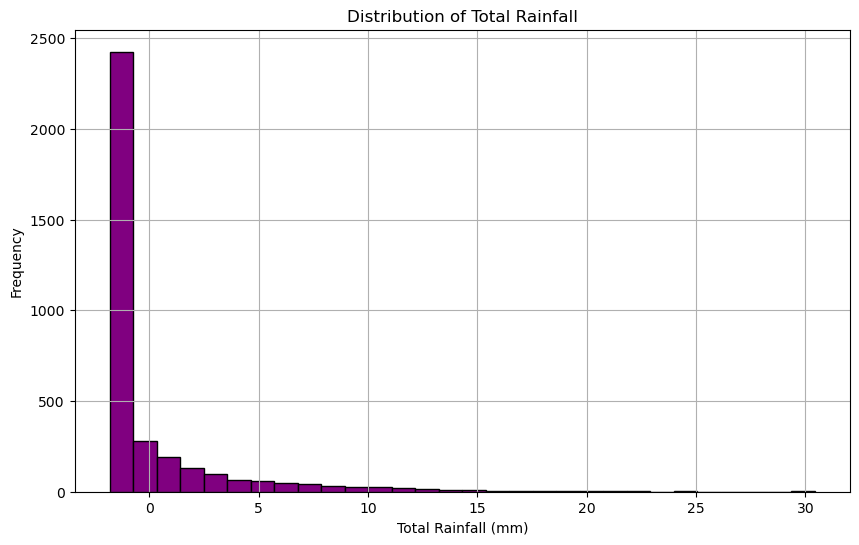

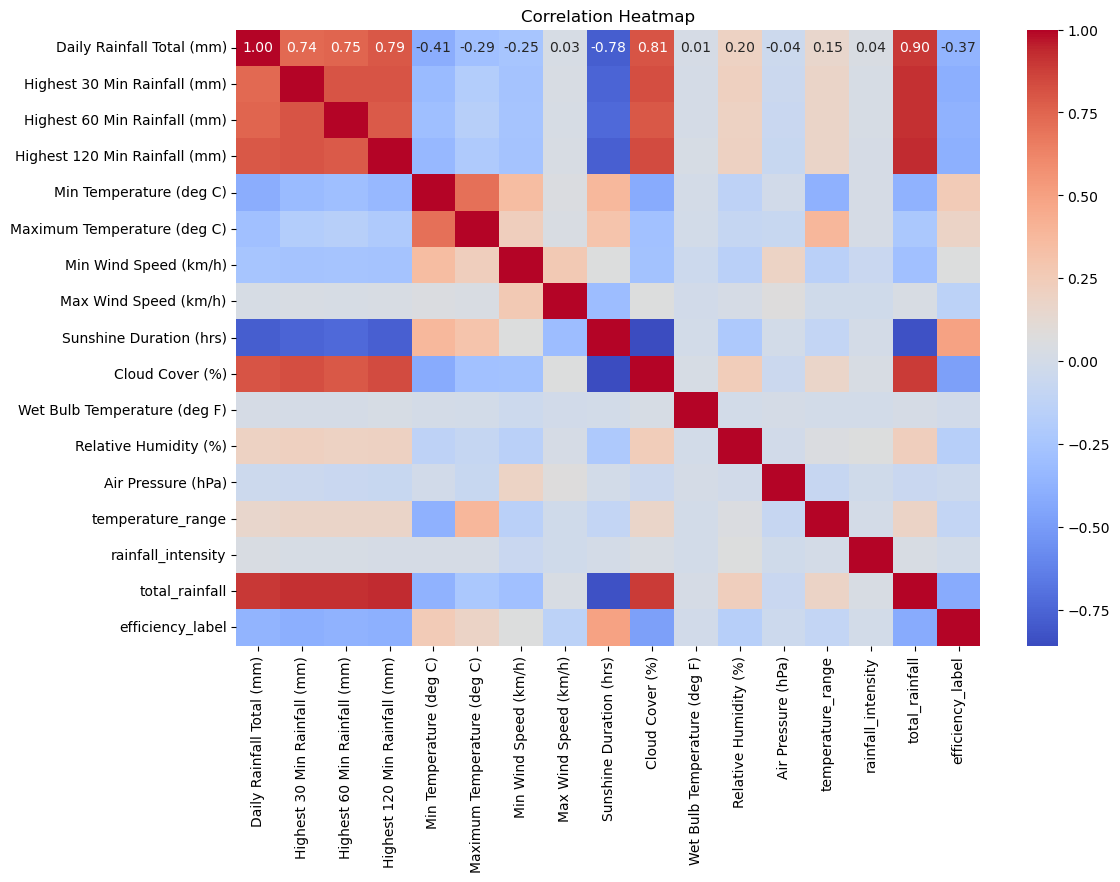

In [17]:
# Visualizations

# Visualizing Total Rainfall
plt.figure(figsize=(10, 6))
plt.hist(weather_df['total_rainfall'], bins=30, color='purple', edgecolor='black')
plt.title('Distribution of Total Rainfall')
plt.xlabel('Total Rainfall (mm)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Select only numeric columns for the correlation matrix
numeric_columns = weather_df.select_dtypes(include=[np.number])

# Correlation heatmap to show the relevance of new features
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_columns.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## Description of Visualizations

# Total rainfall
The histogram of total_rainfall shows a right-skewed distribution, where most of the values are concentrated near zero, and a few values extend towards higher amounts of rainfall. Here are some key observations:

Right Skew: The majority of the days have low total rainfall, with a sharp decrease in frequency as the total rainfall increases.
Outliers: There are some days with significantly higher rainfall, which are less frequent.

# Correlation heatmap with new features
We have created three new features, namely rainfall_intensity, total_rainfall and temperature_range. While rainfall_intensity shows very weak correlation of 0.04 and efficiency label shows a low correlation of 0.15, it is observed that a high correlation of 0.9 for the total_rainfall feature with another feature (likely Daily Rainfall Total (mm)) indicates that this composite feature is highly relevant. Visualizing this new composite feature can help to understand its distribution and its impact on the target variable.

## More visualizations to visualize relationships between features and target variable
### Explanation of Feature Selection for Visualization
In our exploratory data analysis (EDA), we selected specific features for detailed visualization to understand their relationships with the target variable (efficiency_label). Here’s a detailed explanation of why these features were chosen:

### Total Rainfall
#### Reason for Selection
Total Rainfall is a composite feature created by summing various rainfall measurements. The correlation heatmap indicated a high correlation (0.9) with the Daily Rainfall Total (mm), suggesting it is a significant predictor of solar panel efficiency.
#### Insights
Visualizing Total Rainfall helps us understand the distribution of rainfall and its impact on solar panel efficiency. We observed a right-skewed distribution with most values clustered near zero, indicating that most days have low rainfall.
### Sunshine Duration (hrs)
#### Reason for Selection
Sunshine Duration directly affects solar panel efficiency by determining the amount of sunlight available for energy generation. The correlation heatmap showed a significant negative correlation with Total Rainfall, indicating that these two features together can provide insights into weather patterns affecting solar efficiency.
#### Insights
Higher sunshine duration is generally associated with higher efficiency labels, while lower sunshine duration corresponds to lower efficiency labels. This relationship is crucial for understanding how weather conditions influence solar panel performance.
### Max Wind Speed (km/h)
#### Reason for Selection
Wind Speed can affect the performance of solar panels by influencing their temperature and cleanliness. It is also related to weather patterns, which can indirectly impact solar efficiency.
#### Insights
Although the correlation heatmap did not show a strong direct correlation between Max Wind Speed and solar efficiency, analyzing its interactions with other features like Total Rainfall and Sunshine Duration can reveal more complex relationships.
### Efficiency Label (Target Variable)
#### Reason for Selection
The efficiency label is the target variable, representing the efficiency of solar panels categorized into Low (0), Medium (1), and High (2). Understanding how the selected features relate to efficiency labels helps us identify patterns and predictors of solar panel performance.
#### Insights
By coloring the data points according to efficiency labels in the pair plot, we can see how different weather conditions (rainfall, sunshine, wind speed) influence the efficiency categories. This visual differentiation aids in identifying conditions that lead to higher or lower efficiency.

C:\ProgramData\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\ProgramData\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping w

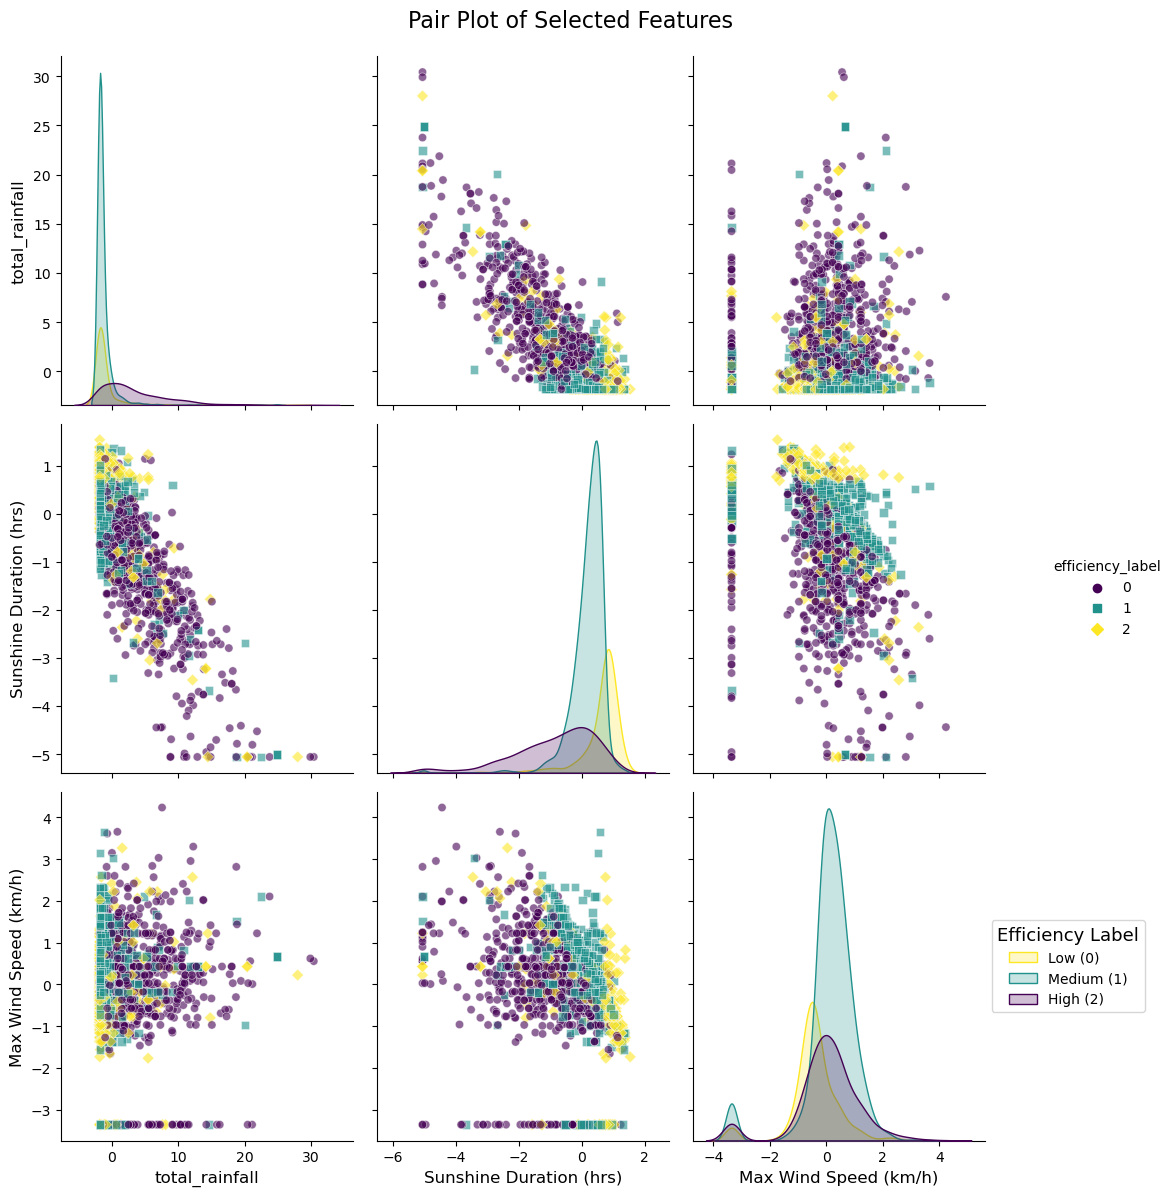

In [18]:
# Adjust pair plot for better readability
subset_features = ['total_rainfall', 'Sunshine Duration (hrs)', 'Max Wind Speed (km/h)', 'efficiency_label']

pair_plot = sns.pairplot(weather_df[subset_features], hue='efficiency_label', palette='viridis', diag_kind='kde', markers=["o", "s", "D"], plot_kws={'alpha': 0.6})

# Increase the size of the plot
pair_plot.fig.set_size_inches(12, 12)

# Adjust titles and labels
for ax in pair_plot.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), fontsize=12)
    ax.set_ylabel(ax.get_ylabel(), fontsize=12)
    # Remove redundant subplot titles
    ax.set_title("")

# Add a main title
pair_plot.fig.suptitle('Pair Plot of Selected Features', y=1.02, fontsize=16)

# Adjust legend position
plt.legend(title='Efficiency Label', title_fontsize='13', loc='center left', bbox_to_anchor=(1, 0.5), labels=['Low (0)', 'Medium (1)', 'High (2)'])

plt.show()

### Pair Plot Analysis

The pair plot provides a visual representation of the relationships between selected features (`total_rainfall`, `Sunshine Duration (hrs)`, `Max Wind Speed (km/h)`) and the target variable (`efficiency_label`). Key observations include:

1. **Total Rainfall**:
   - The distribution is heavily right-skewed with most values clustered at lower levels.
   - There is a noticeable negative correlation between `total_rainfall` and `Sunshine Duration`, indicating that higher rainfall generally corresponds to lower sunshine durations.
   - The efficiency labels are mostly concentrated at lower rainfall levels, with `Low` efficiency being the most frequent.

2. **Sunshine Duration**:
   - Higher sunshine durations tend to be associated with higher efficiency labels (`Medium` and `High`).

3. **Max Wind Speed**:
   - There is no clear relationship between `Max Wind Speed` and `total_rainfall`.
   - `Max Wind Speed` shows some spread across different efficiency labels, but no strong pattern emerges.

Overall, the pair plot helps identify significant relationships and distributions within the dataset, guiding feature selection and engineering for model building.


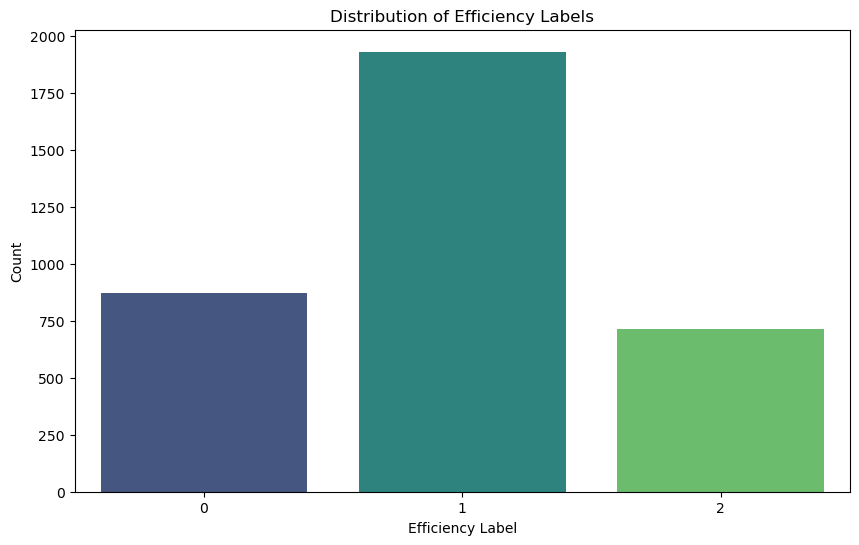

In [19]:
# Bar plot of efficiency label distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='efficiency_label', data=weather_df, palette='viridis')
plt.title('Distribution of Efficiency Labels')
plt.xlabel('Efficiency Label')
plt.ylabel('Count')
plt.show()

### Analysis of the Distribution of Efficiency Labels

The bar plot shows the distribution of efficiency labels (`efficiency_label`) in the dataset. The efficiency labels are categorized into three groups:
- **Low Efficiency (0)**
- **Medium Efficiency (1)**
- **High Efficiency (2)**

#### Key Observations:

1. **Imbalance in Distribution**:
   - **Medium Efficiency (1)**: The majority of the data points fall into this category, with nearly 2000 instances.
   - **Low Efficiency (0)**: This category has a moderate number of instances, with around 1000 instances.
   - **High Efficiency (2)**: This category has the fewest instances, with around 750 instances.

2. **Class Imbalance**:
   - The distribution shows a clear imbalance among the efficiency labels, with the `Medium Efficiency` category being the most common. This imbalance can impact the performance of machine learning models, especially those that assume a balanced distribution of classes.

### Implications for Model Building:

1. **Handling Class Imbalance**:
   - **Resampling Techniques**: Use oversampling (e.g., SMOTE) for the minority class (High Efficiency) or undersampling for the majority class (Medium Efficiency) to balance the classes.
   - **Class Weighting**: Apply class weights in algorithms to give more importance to the minority class.
   - **Evaluation Metrics**: Use metrics like precision, recall, F1-score, and ROC-AUC that are robust to class imbalance rather than relying solely on accuracy.

2. **Feature Importance**:
   - Analyzing the distribution of efficiency labels helps in understanding the significance of the features. For instance, features that effectively distinguish between these categories are crucial for model performance.

### Conclusion:

Understanding the distribution of efficiency labels is essential for effective model training and evaluation. The observed class imbalance highlights the need for strategies to mitigate its impact, ensuring the model performs well across all categories.


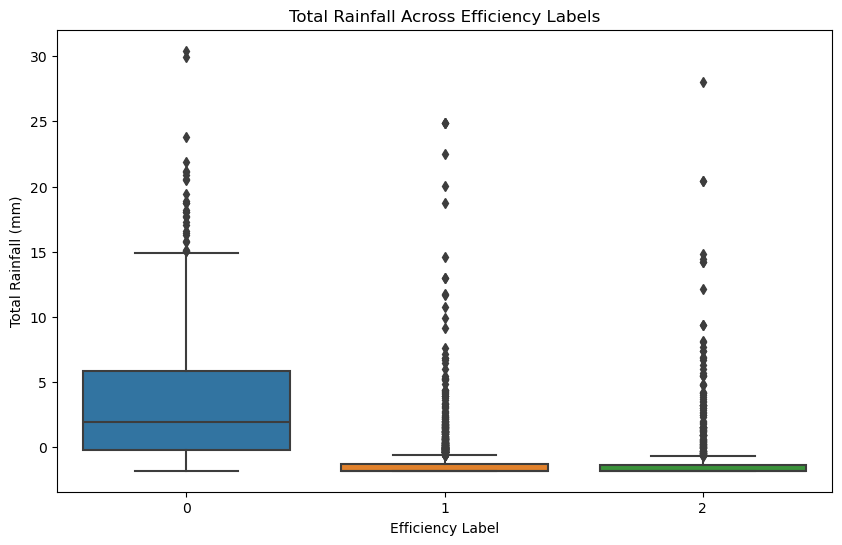

In [20]:
# Box plot for Total Rainfall across Efficiency Labels
plt.figure(figsize=(10, 6))
sns.boxplot(x='efficiency_label', y='total_rainfall', data=weather_df)
plt.title('Total Rainfall Across Efficiency Labels')
plt.xlabel('Efficiency Label')
plt.ylabel('Total Rainfall (mm)')
plt.show()

### Analysis of Total Rainfall Across Efficiency Labels

The box plot visualizes the distribution of total rainfall across the three efficiency labels (`efficiency_label`). Here’s a detailed analysis:

#### Key Observations:

1. **Total Rainfall and Efficiency Labels**:
   - **Low Efficiency (0)**: 
     - The median total rainfall is higher compared to other efficiency labels.
     - There is a wider interquartile range (IQR), indicating more variability in total rainfall.
     - Several outliers are observed, extending up to 30 mm.
   - **Medium Efficiency (1)**: 
     - The median total rainfall is significantly lower.
     - The IQR is very narrow, suggesting that most values are clustered close to the median.
     - Outliers are still present but less frequent than in the low efficiency category.
   - **High Efficiency (2)**: 
     - Similar to the medium efficiency category, the median total rainfall is very low.
     - The IQR is narrow, indicating low variability in total rainfall.
     - Outliers are present but less frequent and lower in value compared to the low efficiency category.

2. **Rainfall and Efficiency Relationship**:
   - **Negative Correlation**: There is a clear negative relationship between total rainfall and efficiency labels. Higher total rainfall is associated with lower efficiency labels (0), while lower total rainfall is associated with higher efficiency labels (1 and 2).

### Implications for Model Building:

1. **Feature Engineering**:
   - Total Rainfall is a significant feature for predicting solar panel efficiency. The negative correlation suggests that higher rainfall negatively impacts solar efficiency, likely due to reduced sunlight availability.

2. **Model Training**:
   - Models should account for the variability and outliers in total rainfall, especially for the low efficiency category.
   - Additional features that capture the duration and intensity of rainfall, along with sunshine duration, can improve model performance.

3. **Handling Outliers**:
   - The presence of outliers in total rainfall can impact model performance. Consider using robust methods to handle outliers, such as transforming the data or using algorithms that are less sensitive to outliers.

### Conclusion:

The box plot highlights the significant impact of total rainfall on solar panel efficiency. Understanding this relationship is crucial for building accurate predictive models. By incorporating total rainfall and related features, we can better predict solar efficiency and account for weather-related variations.


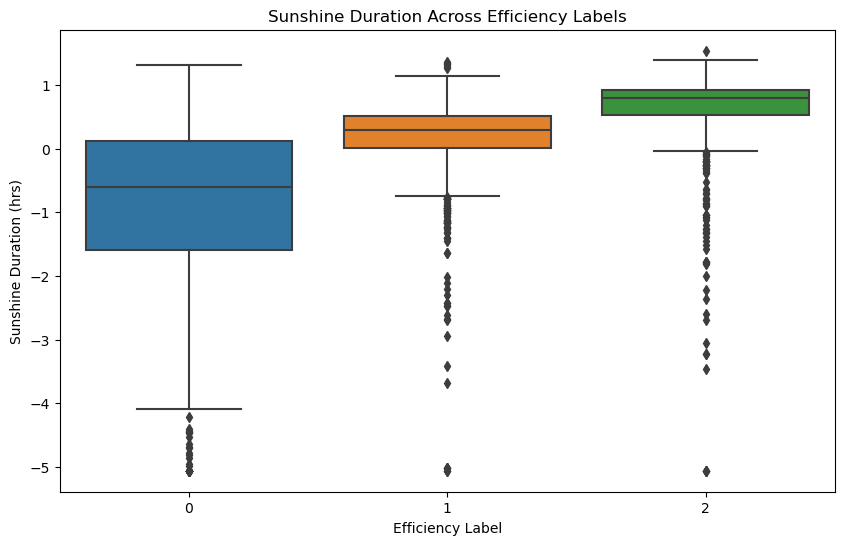

In [21]:
# Box plot for Sunshine Duration across Efficiency Labels
plt.figure(figsize=(10, 6))
sns.boxplot(x='efficiency_label', y='Sunshine Duration (hrs)', data=weather_df)
plt.title('Sunshine Duration Across Efficiency Labels')
plt.xlabel('Efficiency Label')
plt.ylabel('Sunshine Duration (hrs)')
plt.show()

### Analysis of Sunshine Duration Across Efficiency Labels

The box plot visualizes the distribution of sunshine duration across the three efficiency labels (`efficiency_label`). Here’s a detailed analysis:

#### Key Observations:

1. **Sunshine Duration and Efficiency Labels**:
   - **Low Efficiency (0)**:
     - The median sunshine duration is lower compared to other efficiency labels.
     - The interquartile range (IQR) is wider, indicating more variability in sunshine duration.
     - There are several outliers, extending to around -5 hours.
   - **Medium Efficiency (1)**:
     - The median sunshine duration is higher than in the low efficiency category.
     - The IQR is narrow, suggesting that most values are clustered close to the median.
     - There are still outliers, but they are less extreme than in the low efficiency category.
   - **High Efficiency (2)**:
     - The median sunshine duration is the highest among the categories.
     - The IQR is narrow, indicating low variability in sunshine duration.
     - Outliers are present but fewer in number and less extreme.

2. **Sunshine Duration and Efficiency Relationship**:
   - **Positive Correlation**: There is a clear positive relationship between sunshine duration and efficiency labels. Lower sunshine duration is associated with lower efficiency labels (0), while higher sunshine duration is associated with higher efficiency labels (1 and 2).

### Implications for Model Building:

1. **Feature Engineering**:
   - Sunshine Duration is a crucial feature for predicting solar panel efficiency. The positive correlation suggests that higher sunshine duration positively impacts solar efficiency.

2. **Model Training**:
   - Models should account for the variability and outliers in sunshine duration, especially for the low efficiency category.
   - Combining sunshine duration with other related features, like total rainfall, can provide a more comprehensive understanding of weather conditions affecting solar efficiency.

3. **Handling Outliers**:
   - The presence of outliers in sunshine duration can impact model performance. Consider using robust methods to handle outliers, such as transforming the data or using algorithms that are less sensitive to outliers.

### Conclusion:

The box plot highlights the significant impact of sunshine duration on solar panel efficiency. Understanding this relationship is crucial for building accurate predictive models. By incorporating sunshine duration and related features, we can better predict solar efficiency and account for weather-related variations.


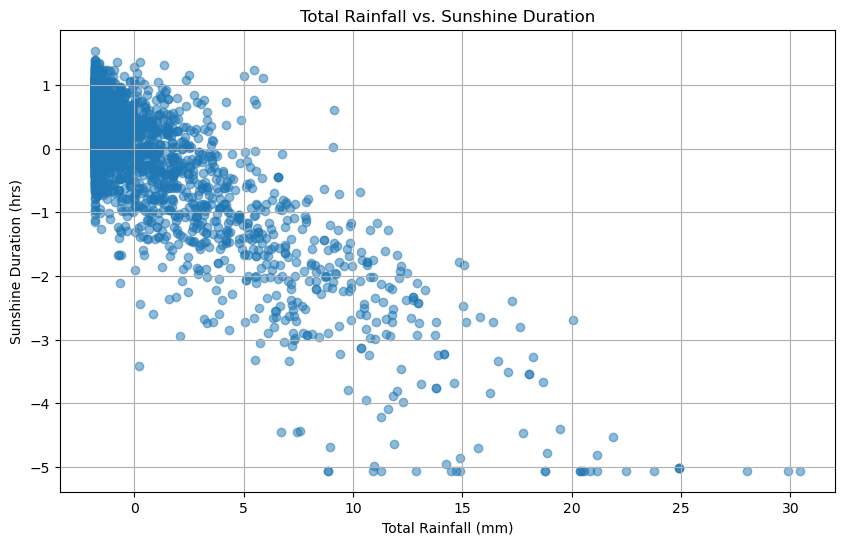

In [22]:
# Scatter plot for Total Rainfall vs. Sunshine Duration
plt.figure(figsize=(10, 6))
plt.scatter(weather_df['total_rainfall'], weather_df['Sunshine Duration (hrs)'], alpha=0.5)
plt.title('Total Rainfall vs. Sunshine Duration')
plt.xlabel('Total Rainfall (mm)')
plt.ylabel('Sunshine Duration (hrs)')
plt.grid(True)
plt.show()

### Analysis of Total Rainfall vs. Sunshine Duration

The scatter plot visualizes the relationship between total rainfall and sunshine duration. Here’s a detailed analysis:

#### Key Observations:

1. **Negative Correlation**:
   - There is a clear negative correlation between total rainfall and sunshine duration. As total rainfall increases, sunshine duration decreases.
   - This inverse relationship is expected, as higher rainfall typically results in cloudier skies and less sunshine.

2. **Distribution Patterns**:
   - Most data points are clustered around low total rainfall values (0-5 mm) and positive sunshine duration values. This indicates that many days have little rainfall and some amount of sunshine.
   - As total rainfall increases beyond 5 mm, the spread of sunshine duration becomes more negative, indicating reduced sunshine on rainier days.

3. **Outliers**:
   - A few outliers with high total rainfall (15-30 mm) and extremely low sunshine duration (down to -5 hours) can be observed. These represent days with heavy rainfall and minimal or no sunshine.

### Implications for Model Building:

1. **Handling Outliers**:
   - The presence of outliers in total rainfall and sunshine duration should be addressed during model training. Robust methods or transformations can help mitigate their impact on the model.

2. **Predictive Insights**:
   - Understanding the relationship between total rainfall and sunshine duration provides valuable insights for predicting solar efficiency. Models can be trained to recognize patterns where high rainfall leads to lower sunshine and, consequently, lower solar panel efficiency.

### Conclusion:

The scatter plot demonstrates a strong negative correlation between total rainfall and sunshine duration. This relationship is crucial for understanding weather patterns that affect solar panel efficiency. By incorporating both features into predictive models, we can better account for the impact of weather conditions on solar performance.


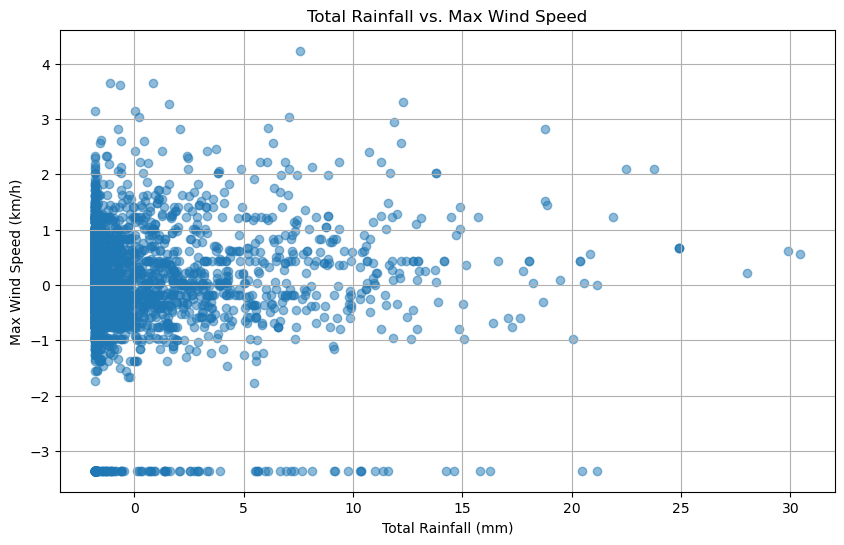

In [23]:
# Scatter plot for Total Rainfall vs. Max Wind Speed
plt.figure(figsize=(10, 6))
plt.scatter(weather_df['total_rainfall'], weather_df['Max Wind Speed (km/h)'], alpha=0.5)
plt.title('Total Rainfall vs. Max Wind Speed')
plt.xlabel('Total Rainfall (mm)')
plt.ylabel('Max Wind Speed (km/h)')
plt.grid(True)
plt.show()

### Analysis of Total Rainfall vs. Max Wind Speed

The scatter plot visualizes the relationship between total rainfall and max wind speed. Here’s a detailed analysis:

#### Key Observations:

1. **Lack of Clear Correlation**:
   - There does not appear to be a strong correlation between total rainfall and max wind speed. The data points are widely dispersed, indicating no clear linear relationship.
   - Max wind speed values vary across different levels of total rainfall, suggesting that wind speed is not directly influenced by rainfall amounts.

2. **Distribution Patterns**:
   - Most data points are clustered around low total rainfall values (0-5 mm) and wind speeds ranging from -1 to 2 km/h.
   - There is a higher concentration of data points at low wind speeds, especially around 0 km/h, indicating that most days experience mild wind conditions.

3. **Outliers**:
   - A few outliers with high total rainfall (15-30 mm) and varying wind speeds can be observed. These represent days with heavy rainfall and different wind conditions.
   - Some data points at the lower extreme of wind speeds (around -3 km/h) and varying rainfall amounts are also visible.

### Implications for Model Building:

1. **Feature Engineering**:
   - Although max wind speed does not show a strong direct correlation with total rainfall, it might still be useful in combination with other features to predict solar panel efficiency.
   - Interaction terms involving max wind speed, total rainfall, and other weather variables can be explored to capture more complex relationships.

2. **Model Training**:
   - Given the lack of a clear correlation, models should consider non-linear relationships and interactions between max wind speed and other features.
   - Incorporating max wind speed can provide additional context to weather conditions, even if it is not a primary predictor.

3. **Handling Outliers**:
   - The presence of outliers in both total rainfall and max wind speed should be addressed during model training. Robust methods or transformations can help mitigate their impact on the model.

### Conclusion:

The scatter plot shows that there is no strong direct correlation between total rainfall and max wind speed. However, understanding the distribution and variability of wind speed in relation to rainfall can still provide valuable insights for predicting solar panel efficiency. Incorporating max wind speed into predictive models, along with other weather features, can enhance model accuracy by capturing a broader range of weather conditions.


### Exploratory Data Analysis Wrap-Up

In this section, we have conducted a comprehensive exploratory data analysis (EDA) to understand the relationships between various weather features and solar panel efficiency. Here’s a summary of what we have explored and the key insights we have gained:

#### Key Features Analyzed:

1. **Total Rainfall**:
   - **Distribution**: The total rainfall feature exhibited a right-skewed distribution, with most days having low rainfall.
   - **Impact on Efficiency**: Higher total rainfall was associated with lower solar panel efficiency. This relationship suggests that rainy days with less sunlight negatively impact solar panel performance.

2. **Sunshine Duration**:
   - **Distribution**: Sunshine duration showed a balanced distribution with a peak around zero, indicating many days with varying sunshine duration.
   - **Impact on Efficiency**: Higher sunshine duration was positively correlated with higher solar panel efficiency, underscoring the importance of sunlight availability for solar power generation.

3. **Max Wind Speed**:
   - **Distribution**: Max wind speed displayed a normal distribution centered around zero, indicating varying wind conditions.
   - **Impact on Efficiency**: Although there was no strong direct correlation with total rainfall, understanding wind conditions can provide additional context to weather patterns affecting solar efficiency.

4. **Efficiency Labels**:
   - **Distribution**: The efficiency labels were imbalanced, with the majority of data points falling into the medium efficiency category. This class imbalance needs to be addressed during model training to ensure balanced performance.

#### Visualizations:

1. **Pair Plot**:
   - **Purpose**: To visualize pairwise relationships between selected features and the efficiency labels. 
   - **Insights**: Revealed significant negative correlations between total rainfall and sunshine duration, and slight positive correlations between sunshine duration and max wind speed.

2. **Box Plots**:
   - **Total Rainfall Across Efficiency Labels**: Highlighted the negative correlation between total rainfall and solar efficiency, with higher rainfall corresponding to lower efficiency.
   - **Sunshine Duration Across Efficiency Labels**: Showed the positive correlation between sunshine duration and solar efficiency, with higher sunshine duration corresponding to higher efficiency.

3. **Scatter Plots**:
   - **Total Rainfall vs. Sunshine Duration**: Demonstrated a strong negative correlation, indicating that higher rainfall leads to reduced sunshine.
   - **Total Rainfall vs. Max Wind Speed**: Showed no clear direct correlation but provided insights into the variability of wind speed under different rainfall conditions.

### Conclusion:

From our exploratory data analysis, we have identified key weather features that significantly impact solar panel efficiency. The relationships between total rainfall, sunshine duration, and max wind speed provide valuable insights for building predictive models. 

### Next Steps:

As we move on to the machine learning pipeline in Part 2 of our case study, we will:

1. **Address Class Imbalance**: Implement techniques such as resampling or class weighting to handle the imbalance in efficiency labels.
2. **Evaluate Feature Engineering**: Review the features we have created and consider potential enhancements to capture more complex relationships between weather conditions and solar efficiency, if necessary.
3. **Model Training and Evaluation**: Build and evaluate machine learning models to predict solar panel efficiency, using robust methods to handle outliers and non-linear relationships.

This concludes the exploratory data analysis section of our case study. We are now equipped with a deep understanding of the dataset and ready to build predictive models to improve solar panel efficiency.
